## Battle of the Neighbourhoods - Week 2

In [1]:
import pandas as pd
import numpy as np
import geocoder
import wget
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

#### Pulling Toronto neighbourhood data

In [2]:
# Using a dataset from the Toronto Open Data Portal about neighbourhoods and their coordinates
data = pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=4326")
data.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,6581,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
1,6582,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
2,6583,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),NaN,NaN,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{u'type': u'Polygon', u'coordinates': (((-79.3..."
3,6584,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),NaN,NaN,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{u'type': u'Polygon', u'coordinates': (((-79.5..."
4,6585,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),NaN,NaN,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{u'type': u'Polygon', u'coordinates': (((-79.4..."


In [3]:
#pull the neighbourhood names and coordinates from the dataframe into a new one
toronto_data = data[['AREA_SHORT_CODE','AREA_NAME','LATITUDE','LONGITUDE']]
toronto_data.head()

,AREA_SHORT_CODE,AREA_NAME,LATITUDE,LONGITUDE
0,94,Wychwood (94),43.676919,-79.425515
1,100,Yonge-Eglinton (100),43.704689,-79.403590
2,97,Yonge-St.Clair (97),43.687859,-79.397871
3,27,York University Heights (27),43.765736,-79.488883
4,31,Yorkdale-Glen Park (31),43.714672,-79.457108


In [4]:
column_names=['Code','Neighbourhood','Latitude','Longitude']
toronto_data.columns = column_names
toronto_data.head()

,Code,Neighbourhood,Latitude,Longitude
0,94,Wychwood (94),43.676919,-79.425515
1,100,Yonge-Eglinton (100),43.704689,-79.403590
2,97,Yonge-St.Clair (97),43.687859,-79.397871
3,27,York University Heights (27),43.765736,-79.488883
4,31,Yorkdale-Glen Park (31),43.714672,-79.457108


In [7]:
#Removing the ID numbers from the 'Neighbourhood' column
toronto_data['Neighbourhood'] = toronto_data.Neighbourhood.str.replace('(\(\d\))', '')
toronto_data['Neighbourhood'] = toronto_data.Neighbourhood.str.replace('(\(\d\d\))', '')
toronto_data['Neighbourhood'] = toronto_data.Neighbourhood.str.replace('(\(\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
toronto_data['Neighbourhood'] = toronto_data['Neighbourhood'].apply(lambda x: x.strip())

C:\Users\jessi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jessi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jessi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [9]:
toronto_data.sort_values(by=['Neighbourhood'],axis=0, inplace=True)
toronto_data=toronto_data.reset_index(drop=True)
toronto_data.head()

,Code,Neighbourhood,Latitude,Longitude
0,129,Agincourt North,43.805441,-79.266712
1,128,Agincourt South-Malvern West,43.788658,-79.265612
2,20,Alderwood,43.604937,-79.541611
3,95,Annex,43.671585,-79.404001
4,42,Banbury-Don Mills,43.737657,-79.349718


In [10]:
neighbourhood_list = pd.DataFrame()
neighbourhood_list[['Neighbourhood']] = toronto_data[['Neighbourhood']]
neighbourhood_list.head()

,Neighbourhood
0,Agincourt North
1,Agincourt South-Malvern West
2,Alderwood
3,Annex
4,Banbury-Don Mills


In [11]:
# Pull neighbourhood demographics data from another Toronto Open Data Portal dataset
demo_input = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/335e3407-d3ca-422a-bfac-e3807cfbe0d5',
                          skiprows=1, sheet_name='RawData-Ref Period 2008')
demo_input.head()

,Neighbourhood,Neighbourhood Id,Total Area,Total Population,Pop - Males,Pop - Females,Pop 0 - 4 years,Pop 5 - 9 years,Pop 10 - 14 years,Pop 15 -19 years,...,Home Repairs Needed,Tenant Average Rent,Low Income Families,Low Income Singles,Low Income Children,Family Income Category,Average Family Income,Household Income Category,Pre-Tax Household Income,After-Tax Household Income
0,West Humber-Clairville,1,30.09,32265,16295,15960,2005,2135,2325,2180,...,365,850,7720,725,643,7720,67240,8960,63415,63977
1,Mount Olive-Silverstone-Jamestown,2,4.60,32130,15900,16230,2680,2680,2685,2285,...,980,875,7715,1177,1206,7720,52745,9265,48145,49601
2,Thistletown-Beaumond Heights,3,3.40,9925,4900,5035,615,625,645,630,...,185,875,2520,305,161,2520,71300,3150,55030,54910
3,Rexdale-Kipling,4,2.50,10725,5205,5525,580,645,665,640,...,300,835,2780,653,135,2775,65215,3880,52430,53779
4,Elms-Old Rexdale,5,2.90,9440,4615,4820,725,700,745,655,...,320,895,2560,255,328,2555,56515,3130,53780,55054


In [12]:
#pull useful data
demo_data = demo_input[['Neighbourhood Id','Total Population','Pop - Males','Pop - Females','   Average Family Income']]

In [13]:
toronto_data = toronto_data.join(demo_data.set_index('Neighbourhood Id'), on='Code')

In [14]:
column_names=['Code','Neighbourhood','Latitude','Longitude','Population','MalePop','FemalePop','AvgIncome']
toronto_data.columns = column_names
toronto_data.head()

,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome
0,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450
1,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350
2,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425
3,95,Annex,43.671585,-79.404001,27480,12955,14530,128785
4,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490


#### Looking at population demographics

In [15]:
#Histogram of neighbourhood populations

Text(0, 0.5, 'Neighbourhoods')

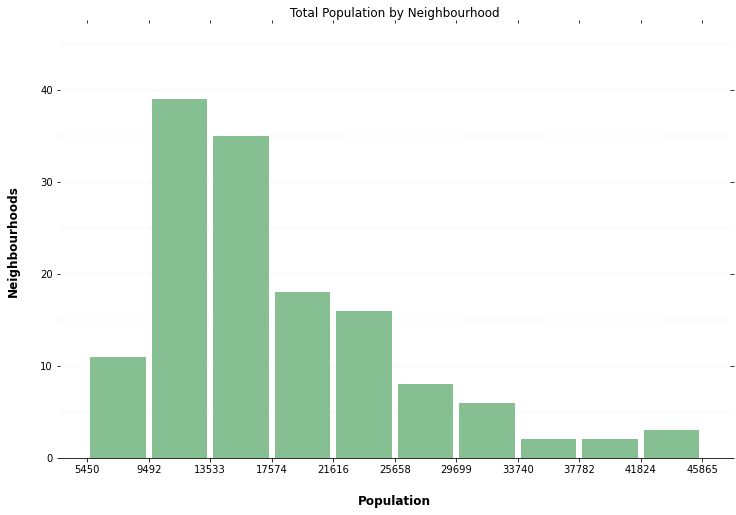

In [16]:
count, bin_edges = np.histogram(toronto_data['Population'])

ax=toronto_data['Population'].plot(kind='hist', grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9,xticks=bin_edges)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Remove title
ax.set_title("Total Population by Neighbourhood")

# Set x-axis label
ax.set_xlabel("Population", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Neighbourhoods", labelpad=20, weight='bold', size=12)

In [17]:
#histogram of Female Population

Text(0, 0.5, 'Neighbourhoods')

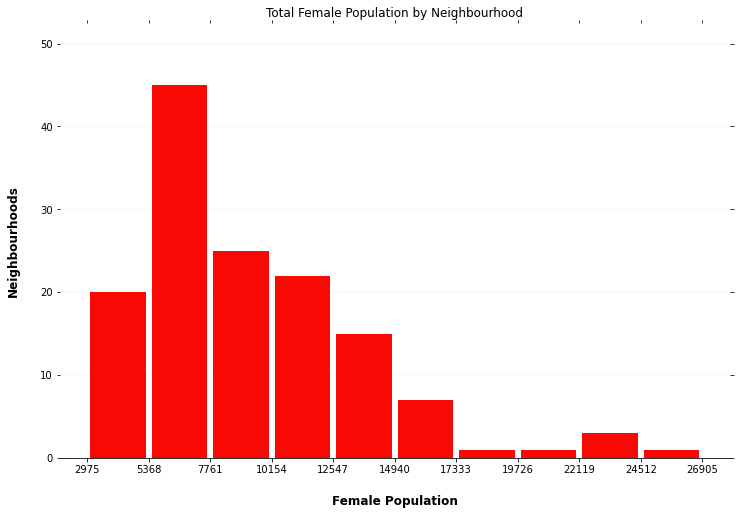

In [44]:
count, bin_edges = np.histogram(toronto_data['FemalePop'])

ax=toronto_data['FemalePop'].plot(kind='hist', grid=False, figsize=(12,8), color='#F90804', zorder=2, rwidth=0.9,xticks=bin_edges)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Remove title
ax.set_title("Total Female Population by Neighbourhood")

# Set x-axis label
ax.set_xlabel("Female Population", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Neighbourhoods", labelpad=20, weight='bold', size=12)

In [19]:
#Histogram of Average Income

Text(0, 0.5, 'Neighbourhoods')

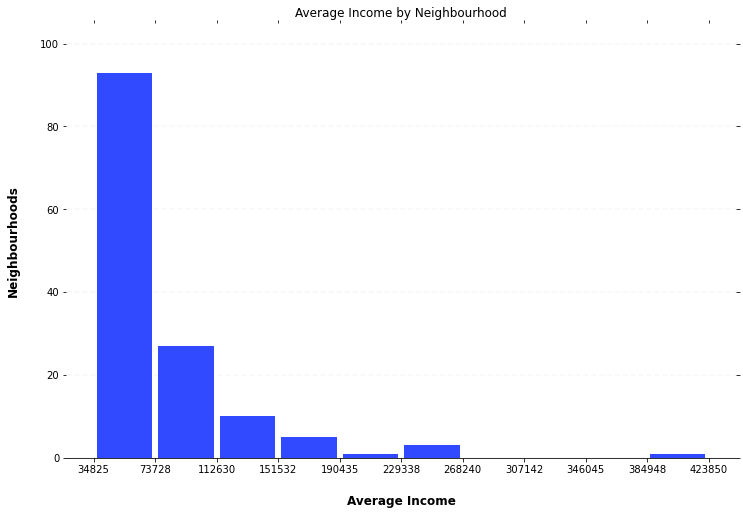

In [46]:
count, bin_edges = np.histogram(toronto_data['AvgIncome'])

ax=toronto_data['AvgIncome'].plot(kind='hist', grid=False, figsize=(12,8), color="#314AFF", zorder=2, rwidth=0.9,xticks=bin_edges)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Remove title
ax.set_title("Average Income by Neighbourhood")

# Set x-axis label
ax.set_xlabel("Average Income", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Neighbourhoods", labelpad=20, weight='bold', size=12)

#### Pulling from Foursquare

In [21]:
#info for Foursquare API
CLIENT_ID = 'LKRBWXNWBXJRACJHS4CGS03A4SMSRTFUJRK5KYC2U4151CUW' # your Foursquare ID
CLIENT_SECRET = 'IJXTWYSMLHBBKD1E5NADM2R54COFTFLH3ES2MULIADDTWCNC' # your Foursquare Secret
VERSION = '20180605'
radius=1000
LIMIT=100

In [22]:
#function to pull venues from Foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# run function on all Toronto Neighbourhoods
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
toronto_venues.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.805441,-79.266712,Menchie's,43.808338,-79.268288,Frozen Yogurt Shop
1,Agincourt North,43.805441,-79.266712,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
2,Agincourt North,43.805441,-79.266712,Dollarama,43.808894,-79.269854,Discount Store
3,Agincourt North,43.805441,-79.266712,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
4,Agincourt North,43.805441,-79.266712,Subway,43.809372,-79.269474,Sandwich Place


In [24]:
toronto_venues.shape

(2020, 7)

#### Preparing All Venues Dataset for modeling

In [25]:
# use one hot encoding to transform the venue categorys (which are strings) into a list of columns with binary values
# one hot encoding the toronto venues dataframe
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()

,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# add postal code column back to the front of the dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighbourhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#group by Neighbourhood and average values
toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()
toronto_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Agincourt South-Malvern West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alderwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Annex,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Banbury-Don Mills,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
toronto_grouped = neighbourhood_list.join(toronto_grouped.set_index('Neighbourhood'), on='Neighbourhood')
toronto_grouped.fillna(value=0, axis=0, inplace=True)

In [29]:
#function to populate a dataframe with the most popular venues for each neighbourhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
#sort dataframe to get top 5 venue categories per postal code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

In [31]:
for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.sort_values(by=['Neighbourhood'],axis=0, inplace=True)
toronto_venues_sorted=toronto_venues_sorted.reset_index(drop=True)
toronto_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Chinese Restaurant,Fast Food Restaurant,Clothing Store,Bakery,Liquor Store,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place,Bank
1,Agincourt South-Malvern West,Chinese Restaurant,Shopping Mall,Restaurant,Pool Hall,Bank,Cantonese Restaurant,Noodle House,Seafood Restaurant,Café,Motorcycle Shop
2,Alderwood,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Hockey Arena,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
3,Annex,Park,Pub,Coffee Shop,Sandwich Place,Café,Pizza Place,Liquor Store,Pet Store,Pharmacy,Convenience Store
4,Banbury-Don Mills,Gourmet Shop,Pizza Place,Coffee Shop,Medical Center,Clothing Store,Italian Restaurant,Liquor Store,Sandwich Place,Cantonese Restaurant,Movie Theater


#### Preparing Salon Only Dataset for modeling

In [32]:
#creating dataframe removing all venues except Salons in order to focus in just on the presence of direct competition
toronto_salons = toronto_venues[(toronto_venues['Venue Category'] == 'Nail Salon') | 
                                (toronto_venues['Venue Category'] == 'Salon / Barbershop')]
toronto_salons = toronto_salons.reset_index(drop=True)
#toronto_salons = toronto_salons.drop('index', axis=1)
toronto_salons.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Blake-Jones,43.676173,-79.337394,Tips Nail Bar,43.679826,-79.340302,Nail Salon
1,Junction Area,43.667890,-79.471440,Lucy Nails,43.665467,-79.471491,Nail Salon
2,Junction Area,43.667890,-79.471440,High Park Nails and Spa,43.665544,-79.474510,Nail Salon
3,L'Amoreaux,43.795716,-79.314084,Ocean Nails Spa,43.795290,-79.320101,Nail Salon
4,Niagara,43.636681,-79.412420,Sparks,43.639090,-79.416229,Nail Salon


In [33]:
# one hot encoding the toronto salons dataframe
toronto_salons_onehot = pd.get_dummies(toronto_salons[['Venue Category']], prefix="", prefix_sep="")
toronto_salons_onehot.head()

,Nail Salon,Salon / Barbershop
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [34]:
# add postal code column back to the front of the dataframe
toronto_salons_onehot['Neighbourhood'] = toronto_salons['Neighbourhood'] 
fixed_columns = [toronto_salons_onehot.columns[-1]] + list(toronto_salons_onehot.columns[:-1])
toronto_salons_onehot = toronto_salons_onehot[fixed_columns]
toronto_salons_onehot.head()

,Neighbourhood,Nail Salon,Salon / Barbershop
0,Blake-Jones,1,0
1,Junction Area,1,0
2,Junction Area,1,0
3,L'Amoreaux,1,0
4,Niagara,1,0


In [35]:
#group by Neighbourhood and average values
toronto_salons_grouped = toronto_salons_onehot.groupby('Neighbourhood').sum().reset_index()
toronto_salons_grouped.head()

,Neighbourhood,Nail Salon,Salon / Barbershop
0,Blake-Jones,1,0
1,Junction Area,2,0
2,L'Amoreaux,1,0
3,Niagara,1,0
4,Palmerston-Little Italy,0,1


In [36]:
#cleaning up data before running model
#merge with demo data and fill NaN values with 0
toronto_salons_joined = toronto_data.join(toronto_salons_grouped.set_index('Neighbourhood'), on='Neighbourhood')
toronto_salons_joined.fillna(value=0, axis=0, inplace=True)
toronto_salons_joined.sort_values(by=['Neighbourhood'],axis=0, inplace=True)
toronto_salons_joined=toronto_salons_joined.reset_index(drop=True)
toronto_salons_joined.head()

,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome,Nail Salon,Salon / Barbershop
0,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450,0.0,0.0
1,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350,0.0,0.0
2,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425,0.0,0.0
3,95,Annex,43.671585,-79.404001,27480,12955,14530,128785,0.0,0.0
4,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490,0.0,0.0


In [37]:
#drop some data that won't be used for clustering
toronto_salons_clustering = toronto_salons_joined.drop(['Neighbourhood','Code','Latitude','Longitude'], 1)
toronto_salons_clustering.head()

,Population,MalePop,FemalePop,AvgIncome,Nail Salon,Salon / Barbershop
0,30160,14505,15655,61450,0.0,0.0
1,21565,10395,11175,61350,0.0,0.0
2,11655,5655,6000,72425,0.0,0.0
3,27480,12955,14530,128785,0.0,0.0
4,25435,11770,13665,103490,0.0,0.0


# Clustering model

In [38]:
#create final dataframe with Neighbourhood venues and demographics
toronto_joined = toronto_data.join(toronto_grouped.set_index('Neighbourhood'), on='Neighbourhood')
toronto_joined.fillna(value=0, axis=0, inplace=True)
toronto_joined.sort_values(by=['Neighbourhood'],axis=0, inplace=True)
toronto_joined=toronto_joined.reset_index(drop=True)
toronto_joined.head()

,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome,African Restaurant,American Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,95,Annex,43.671585,-79.404001,27480,12955,14530,128785,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#drop some data that won't be used for clustering
toronto_grouped_clustering = toronto_joined.drop(['Neighbourhood','Code','Latitude','Longitude'], 1)

In [40]:
toronto_grouped_clustering.head()

,Population,MalePop,FemalePop,AvgIncome,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,30160,14505,15655,61450,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21565,10395,11175,61350,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11655,5655,6000,72425,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27480,12955,14530,128785,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25435,11770,13665,103490,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#normalize the data
from sklearn.preprocessing import StandardScaler
X = toronto_grouped_clustering
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.50329843,  1.44901217,  1.46542683, ..., -0.26686769,
        -0.11412538, -0.08481889],
       [ 0.4521483 ,  0.44002477,  0.43797105, ..., -0.26686769,
        -0.11412538, -0.08481889],
       [-0.75982351, -0.72362493, -0.74887799, ..., -0.26686769,
        -0.11412538, -0.08481889],
       ...,
       [-0.81180011, -0.88196967, -0.69498243, ...,  3.12963018,
        -0.11412538, -0.08481889],
       [ 1.01166102,  1.02675954,  0.93564494, ..., -0.26686769,
        -0.11412538, -0.08481889],
       [-0.37213929, -0.41921024, -0.30739308, ..., -0.26686769,
        -0.11412538, -0.08481889]])

#### Figuring out good cluster number using elbow method for all venues dataset

In [49]:
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer

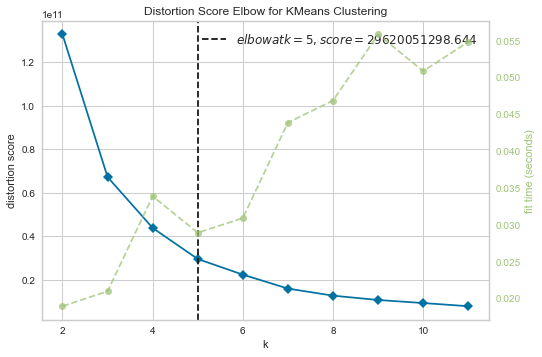

In [50]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

From this, we can see that the elbow method gives us a cluster number of 5. The elbow point is now sharp, however, so using 4 or 6 might also be acceptable.

#### Running the model on all venues

In [51]:
#run the model with a starting number for the number of clusters
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[4 4 0 2 0 4 0 0 0 2 4 4 0 4 4 4 3 4 4 0 4 1 0 4 4 0 0 4 0 4 4 4 4 4 4 0 2
 4 4 0 0 4 4 2 1 4 4 0 4 0 0 0 0 0 4 4 0 4 4 0 4 4 4 4 1 4 2 2 2 1 2 4 0 4
 4 0 4 0 4 0 4 4 2 4 4 0 4 0 0 4 4 4 4 0 0 4 0 0 4 2 4 4 4 0 1 4 0 4 4 4 4
 2 4 0 4 4 2 0 4 4 0 4 0 4 4 4 4 4 4 4 0 0 4 0 4 0 2 2 4 4]


In [52]:
#adding the cluster values to the dataframe
toronto_grouped_clustering["Cluster"] = labels
fixed_columns = [toronto_grouped_clustering.columns[-1]] + list(toronto_grouped_clustering.columns[:-1])
toronto_grouped_clustering = toronto_grouped_clustering[fixed_columns]

In [53]:
# add clustering labels to our Top Venues table
toronto_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_)
toronto_venues_sorted['Cluster Labels'] = toronto_venues_sorted['Cluster Labels'].astype(int)
toronto_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Agincourt North,Chinese Restaurant,Fast Food Restaurant,Clothing Store,Bakery,Liquor Store,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place,Bank
1,4,Agincourt South-Malvern West,Chinese Restaurant,Shopping Mall,Restaurant,Pool Hall,Bank,Cantonese Restaurant,Noodle House,Seafood Restaurant,Café,Motorcycle Shop
2,0,Alderwood,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Hockey Arena,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
3,2,Annex,Park,Pub,Coffee Shop,Sandwich Place,Café,Pizza Place,Liquor Store,Pet Store,Pharmacy,Convenience Store
4,0,Banbury-Don Mills,Gourmet Shop,Pizza Place,Coffee Shop,Medical Center,Clothing Store,Italian Restaurant,Liquor Store,Sandwich Place,Cantonese Restaurant,Movie Theater


In [54]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged_venues = toronto_data.join(toronto_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged_venues.dropna(axis=0, inplace=True)
toronto_merged_venues['Cluster Labels'] = toronto_merged_venues['Cluster Labels'].astype(int)

In [55]:
fixed_cols = ['Cluster Labels', 'Code', 'Neighbourhood', 'Latitude', 'Longitude', 'Population',
       'MalePop', 'FemalePop', 'AvgIncome', 
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']
toronto_merged_venues = toronto_merged_venues[fixed_cols]
toronto_merged_venues.head()

,Cluster Labels,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450,Chinese Restaurant,Fast Food Restaurant,Clothing Store,Bakery,Liquor Store,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place,Bank
1,4,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350,Chinese Restaurant,Shopping Mall,Restaurant,Pool Hall,Bank,Cantonese Restaurant,Noodle House,Seafood Restaurant,Café,Motorcycle Shop
2,0,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Hockey Arena,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
3,2,95,Annex,43.671585,-79.404001,27480,12955,14530,128785,Park,Pub,Coffee Shop,Sandwich Place,Café,Pizza Place,Liquor Store,Pet Store,Pharmacy,Convenience Store
4,0,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490,Gourmet Shop,Pizza Place,Coffee Shop,Medical Center,Clothing Store,Italian Restaurant,Liquor Store,Sandwich Place,Cantonese Restaurant,Movie Theater


Now for the Salon dataframe

#### figuring out K value for salons

In [56]:
#normalize the data
X2 = toronto_salons_clustering
X2 = np.nan_to_num(X2)
Clus_salons_dataSet = StandardScaler().fit_transform(X2)
Clus_salons_dataSet

array([[ 1.50329843e+00,  1.44901217e+00,  1.46542683e+00,
        -4.02084457e-01, -1.82237022e-01, -1.20385853e-01],
       [ 4.52148300e-01,  4.40024771e-01,  4.37971046e-01,
        -4.04160485e-01, -1.82237022e-01, -1.20385853e-01],
       [-7.59823515e-01, -7.23624931e-01, -7.48877985e-01,
        -1.74240330e-01, -1.82237022e-01, -1.20385853e-01],
       [ 1.17554016e+00,  1.06849381e+00,  1.20741617e+00,
         9.95809328e-01, -1.82237022e-01, -1.20385853e-01],
       [ 9.25441027e-01,  7.77581383e-01,  1.00903464e+00,
         4.70677921e-01, -1.82237022e-01, -1.20385853e-01],
       [-3.57463548e-01, -3.79930926e-01, -3.16566792e-01,
        -2.84685046e-01, -1.82237022e-01, -1.20385853e-01],
       [-3.11601850e-01, -3.02599775e-01, -3.00512796e-01,
        -2.58630888e-01, -1.82237022e-01, -1.20385853e-01],
       [-3.05486957e-01, -3.33286740e-01, -2.61524518e-01,
         2.12177526e-02, -1.82237022e-01, -1.20385853e-01],
       [-5.59255021e-01, -5.89829765e-01, -4.977

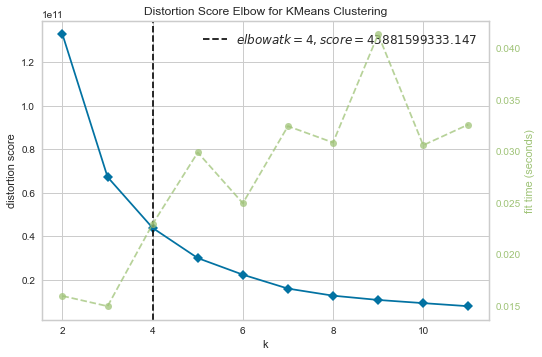

In [57]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show() 

Once again, the best number of clusters will be 5, though like with all venues, it's not a sharp elbow point.

#### Running model

In [58]:
#run the model with a starting number for the number of clusters
clusterNum2 = 5
k_means2 = KMeans(init = "k-means++", n_clusters = clusterNum2, n_init = 12)
k_means2.fit(X2)
labels2 = k_means2.labels_
print(labels2)

[4 4 0 2 0 4 0 0 0 2 4 4 0 4 4 4 3 4 4 0 4 1 0 4 4 0 0 4 0 4 4 4 4 4 4 0 2
 4 4 0 0 4 4 2 1 4 4 0 4 0 0 0 0 0 4 4 0 4 4 0 4 4 4 4 2 4 2 2 2 1 2 4 0 4
 4 0 4 0 4 0 4 4 2 4 4 0 4 0 0 4 4 4 4 0 0 4 0 0 4 2 4 4 4 0 1 4 0 4 4 4 4
 2 4 0 4 4 2 0 4 4 0 4 0 4 4 4 4 4 4 4 0 0 4 0 4 0 2 2 4 4]


In [59]:
#adding the cluster values to the dataframe
toronto_salons_clustering["Cluster"] = labels2
fixed_columns = [toronto_salons_clustering.columns[-1]] + list(toronto_salons_clustering.columns[:-1])
toronto_salons_clustering = toronto_salons_clustering[fixed_columns]
toronto_salons_clustering.head()

,Cluster,Population,MalePop,FemalePop,AvgIncome,Nail Salon,Salon / Barbershop
0,4,30160,14505,15655,61450,0.0,0.0
1,4,21565,10395,11175,61350,0.0,0.0
2,0,11655,5655,6000,72425,0.0,0.0
3,2,27480,12955,14530,128785,0.0,0.0
4,0,25435,11770,13665,103490,0.0,0.0


In [60]:
# add clustering labels to our Top Venues table
toronto_merged_salons = toronto_merged_venues
toronto_merged_salons = toronto_merged_salons.drop(['Cluster Labels'], axis=1)
toronto_merged_salons.insert(0, 'Cluster Labels', labels2)
toronto_merged_salons['Cluster Labels'] = toronto_merged_salons['Cluster Labels'].astype(int)
toronto_merged_salons.head()

,Cluster Labels,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450,Chinese Restaurant,Fast Food Restaurant,Clothing Store,Bakery,Liquor Store,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place,Bank
1,4,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350,Chinese Restaurant,Shopping Mall,Restaurant,Pool Hall,Bank,Cantonese Restaurant,Noodle House,Seafood Restaurant,Café,Motorcycle Shop
2,0,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Hockey Arena,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
3,2,95,Annex,43.671585,-79.404001,27480,12955,14530,128785,Park,Pub,Coffee Shop,Sandwich Place,Café,Pizza Place,Liquor Store,Pet Store,Pharmacy,Convenience Store
4,0,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490,Gourmet Shop,Pizza Place,Coffee Shop,Medical Center,Clothing Store,Italian Restaurant,Liquor Store,Sandwich Place,Cantonese Restaurant,Movie Theater


#### Create Map

In [61]:
# create map for all venues dataset
latitude = 43.6532
longitude = -79.3832
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_venues['Latitude'], toronto_merged_venues['Longitude'], 
                                  toronto_merged_venues['Neighbourhood'], toronto_merged_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [62]:
# create map for salon venues dataset
latitude = 43.6532
longitude = -79.3832
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum2)
ys = [i + x + (i*x)**2 for i in range(clusterNum2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_salons['Latitude'], toronto_merged_salons['Longitude'], 
                                  toronto_merged_salons['Neighbourhood'], toronto_merged_salons['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

## Looking at the Cluster results

#### All venues

In [63]:
#When looking at all venues for every neighbourhood
toronto_merged_venues

,Cluster Labels,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450,Chinese Restaurant,Fast Food Restaurant,Clothing Store,Bakery,Liquor Store,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place,Bank
1,4,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350,Chinese Restaurant,Shopping Mall,Restaurant,Pool Hall,Bank,Cantonese Restaurant,Noodle House,Seafood Restaurant,Café,Motorcycle Shop
2,0,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Hockey Arena,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
3,2,95,Annex,43.671585,-79.404001,27480,12955,14530,128785,Park,Pub,Coffee Shop,Sandwich Place,Café,Pizza Place,Liquor Store,Pet Store,Pharmacy,Convenience Store
4,0,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490,Gourmet Shop,Pizza Place,Coffee Shop,Medical Center,Clothing Store,Italian Restaurant,Liquor Store,Sandwich Place,Cantonese Restaurant,Movie Theater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0,94,Wychwood,43.676919,-79.425515,14200,6600,7590,81905,Farmers Market,Event Space,Coffee Shop,Park,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Zoo Exhibit
136,2,100,Yonge-Eglinton,43.704689,-79.403590,10500,4920,5575,122960,Coffee Shop,Fast Food Restaurant,Movie Theater,Gym,Restaurant,Liquor Store,Japanese Restaurant,Juice Bar,Poutine Place,Supermarket
137,2,97,Yonge-St.Clair,43.687859,-79.397871,11230,5010,6235,139915,Coffee Shop,Italian Restaurant,Sushi Restaurant,Grocery Store,Pub,Café,Pizza Place,Thai Restaurant,Bagel Shop,Pharmacy
138,4,27,York University Heights,43.765736,-79.488883,26140,12785,13345,52560,Miscellaneous Shop,Furniture / Home Store,Bar,Bank,Caribbean Restaurant,Falafel Restaurant,Japanese Restaurant,Coffee Shop,Fast Food Restaurant,Massage Studio


In [85]:
def cluster_sum(x):
    d = {}
    d['Cluster'] = x['Cluster']
    d['Count'] = x['Population'].count()
    d['Population Avg'] = x['Population'].mean()
    d['FemalePop Avg'] = x['FemalePop'].mean()
    d['AvgIncome'] = x['AvgIncome'].mean()
    d['Nail Salon'] = x['Nail Salon'].mean()
    d['Salon / Barbershop'] = x['Salon / Barbershop'].mean()
    
    return pd.Series(d,index=['Count','Population Avg','FemalePop Avg','AvgIncome','Nail Salon','Salon / Barbershop'])

In [86]:
toronto_grouped_clustering.head()

,Cluster,Population,MalePop,FemalePop,AvgIncome,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,4,30160,14505,15655,61450,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,21565,10395,11175,61350,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,11655,5655,6000,72425,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,27480,12955,14530,128785,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,25435,11770,13665,103490,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
#Averaging the demographics and relevant venue category values by cluster. 
# including a count of neighbourhoods per cluster
cluster_avg_all_venues = toronto_grouped_clustering.groupby('Cluster').apply(cluster_sum)
cluster_avg_all_venues[['Population Avg','FemalePop Avg','AvgIncome']]=cluster_avg_all_venues[['Population Avg','FemalePop Avg','AvgIncome']].astype(int)
cluster_avg_all_venues

,Count,Population Avg,FemalePop Avg,AvgIncome,Nail Salon,Salon / Barbershop
Cluster,,,,,,
0,43,14667,7644,79652,0.069767,0.023256
1,5,12973,6953,226033,0.000000,0.000000
2,14,15287,8112,135871,0.071429,0.071429
3,1,8210,4055,423850,0.000000,0.000000
4,77,20567,10597,57574,0.025974,0.000000


In [ ]:
#For all venues
#cluster_averages=toronto_grouped_clustering.groupby('Cluster').agg({'Population':'mean','FemalePop':'mean','AvgIncome':'mean',
#                                                   'Nail Salon':'mean','Salon / Barbershop':'mean'})
#cluster_averages[['Population','FemalePop','AvgIncome']]=cluster_averages[['Population','FemalePop','AvgIncome']].astype(int)

From this data, as a prospective owner of a nail/hair salon, this information could help me figure out which neighbourhoods to consider when selecting where to build my business.

Looking at clusters 0,2,4 as the only clusters with nail salons, and 0 and 4 as the only clusters with slaon/barbershops, I can infer that there's something about those clusters that make this type of business more viable than in others. 

So I might look at the list of neighbourhoods to find the neighbourhoods that belong to those clusters to help find even more similarities between them. This algorithm has narrowed down the list for me from the 140 neighbourhoods I started with.

For example, we might want to add data on foot traffic vs road traffic, whether clients are local residents or commuters, if there are zoning or tax considerations, etc.

#### Salon-only results

In [92]:
toronto_merged_salons

,Cluster Labels,Code,Neighbourhood,Latitude,Longitude,Population,MalePop,FemalePop,AvgIncome,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,129,Agincourt North,43.805441,-79.266712,30160,14505,15655,61450,Chinese Restaurant,Fast Food Restaurant,Clothing Store,Bakery,Liquor Store,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Sandwich Place,Bank
1,4,128,Agincourt South-Malvern West,43.788658,-79.265612,21565,10395,11175,61350,Chinese Restaurant,Shopping Mall,Restaurant,Pool Hall,Bank,Cantonese Restaurant,Noodle House,Seafood Restaurant,Café,Motorcycle Shop
2,0,20,Alderwood,43.604937,-79.541611,11655,5655,6000,72425,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Hockey Arena,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
3,2,95,Annex,43.671585,-79.404001,27480,12955,14530,128785,Park,Pub,Coffee Shop,Sandwich Place,Café,Pizza Place,Liquor Store,Pet Store,Pharmacy,Convenience Store
4,0,42,Banbury-Don Mills,43.737657,-79.349718,25435,11770,13665,103490,Gourmet Shop,Pizza Place,Coffee Shop,Medical Center,Clothing Store,Italian Restaurant,Liquor Store,Sandwich Place,Cantonese Restaurant,Movie Theater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0,94,Wychwood,43.676919,-79.425515,14200,6600,7590,81905,Farmers Market,Event Space,Coffee Shop,Park,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Zoo Exhibit
136,2,100,Yonge-Eglinton,43.704689,-79.403590,10500,4920,5575,122960,Coffee Shop,Fast Food Restaurant,Movie Theater,Gym,Restaurant,Liquor Store,Japanese Restaurant,Juice Bar,Poutine Place,Supermarket
137,2,97,Yonge-St.Clair,43.687859,-79.397871,11230,5010,6235,139915,Coffee Shop,Italian Restaurant,Sushi Restaurant,Grocery Store,Pub,Café,Pizza Place,Thai Restaurant,Bagel Shop,Pharmacy
138,4,27,York University Heights,43.765736,-79.488883,26140,12785,13345,52560,Miscellaneous Shop,Furniture / Home Store,Bar,Bank,Caribbean Restaurant,Falafel Restaurant,Japanese Restaurant,Coffee Shop,Fast Food Restaurant,Massage Studio


In [96]:
#cluster_averages_salon=toronto_salons_clustering.groupby('Cluster').agg({'Population':'mean','FemalePop':'mean','AvgIncome':'mean',
#                                                  'Nail Salon':'mean','Salon / Barbershop':'mean'})
#cluster_averages_salon=toronto_salons_clustering.groupby('Cluster').avg()
cluster_averages_salon = toronto_salons_clustering.groupby('Cluster').apply(cluster_sum)
cluster_averages_salon[['Population Avg','FemalePop Avg','AvgIncome']]=cluster_averages_salon[['Population Avg','FemalePop Avg','AvgIncome']].astype(int)
cluster_averages_salon

,Count,Population Avg,FemalePop Avg,AvgIncome,Nail Salon,Salon / Barbershop
Cluster,,,,,,
0,43,14667,7644,79652,0.069767,0.023256
1,4,14018,7535,237051,0.000000,0.000000
2,15,14854,7880,138944,0.066667,0.066667
3,1,8210,4055,423850,0.000000,0.000000
4,77,20567,10597,57574,0.025974,0.000000


Once again, we have nail salons in three of our clusters, and salon/barbershops in two, with overlap between them.

It's also quite noticeable that the two clusters with the highest average income have no salons at all, contradicting my earlier hypothesis about disposable income being a key factor.